# Analysis of 10X Genomics 1 Million Cells

In [10]:
%matplotlib notebook

import pylab as plt
import matplotlib
# import seaborn as sns; sns.set()
# import scipy
import numpy as np
import pandas as pd
# import pickle
# import tables


import sys
sys.path.append('/home/jjl148/builds/FIt-SNE')
from fast_tsne import fast_tsne


import scanpy as sc
sc.settings.verbosity = 2

## Load Data and Preprocess

The 10X Genomics dataset is 1.3 million brain cells of the cortex, hippocampus and subventricular zones of two E13 mice. Because the dataset was so large, the server could not process it and the notebook kept crashing. Instead, I used a sub-sample of 20,000 cell provided by 10X Genomics.

The quality control and feature selection step is done by a function in scanpy that preproccesses the single cell RNA-seq data according to [Zheng17](https://www.nature.com/articles/ncomms14049). The function does a low count filter, normalizes and selects the top 1000 highly variable the genes.

In [3]:
# Data file is from here 
# https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.3.0/1M_neurons
adata = sc.read_10x_h5('data/TenX/1M_neurons_neuron20k.h5')
sc.pp.recipe_zheng17(adata)

# load cluster labels
# https://github.com/theislab/scanpy_usage/blob/master/170522_visualizing_one_million_cells/results/louvain.csv.gz
clusters = pd.read_csv('data/TenX/louvain.csv', header=None).values[:,[0:1]].astype(int)

reading data/TenX/1M_neurons_neuron20k.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
running recipe zheng17
filtered out 8232 genes that are detected in less than 1 counts


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:02)


## Perform PCA

PCA algorithm taken from [Kobak19](https://www.nature.com/articles/s41467-019-13056-x). Code available at (https://github.com/berenslab/)

In [4]:
X = np.copy(adata.X)
X = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X, full_matrices=False)
U[:, np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

In [5]:
X.shape

(20000, 50)

The t-SNE is computed on the top 50 PC's after principal component analysis after PCA and initialized with the first two PC's after dividing them by the standard deviation of the first PC and multiplying by 0.0001.

In [6]:
PCAinit = X[:,:2] / np.std(X[:,0]) * 0.0001

In [7]:
tsne = fast_tsne(X, perplexity_list=[30,int(20000/100)], 
                 initialization = PCAinit, seed=42, 
                 learning_rate = 20000/12)

In [8]:
tsne

array([[ 16.88106862,   7.69266317],
       [ 31.04642098,   7.12699542],
       [ 34.65952205,  33.18357531],
       ...,
       [-17.43544662, -52.26365324],
       [-32.93587428,  41.96638098],
       [-26.55953559,  45.43339641]])

In [17]:
tsne.shape

(20000, 2)

Get the marker gene expression matrix

In [45]:
import scipy.sparse as sp_sparse
import tables
 
f = tables.open_file('./data/TenX/1M_neurons_neuron20k.h5', 'r')
group = f.get_node(f.root, 'mm10')
gene_ids = getattr(group, 'genes').read()
gene_names = getattr(group, 'gene_names').read().astype(str)
barcodes = getattr(group, 'barcodes').read()
data = getattr(group, 'data').read()
indices = getattr(group, 'indices').read()
indptr = getattr(group, 'indptr').read()
shape = getattr(group, 'shape').read()

matrix = sp_sparse.csc_matrix((data, indices, indptr), shape=shape)

markers = ['Aldoc', 'Eomes', 'Stmn2', 'Gad1', 'Gad2']

markerind   = np.array([i for i,g in enumerate(gene_names) if g in markers])
markergenes = np.array([g for i,g in enumerate(gene_names) if g in markers])
markerexp   = np.array(matrix[markerind,:].todense()).T.astype('float')

In [46]:
markerind

array([ 1867,  2409,  5164, 18983, 20125])

In [47]:
markergenes

array(['Gad2', 'Gad1', 'Stmn2', 'Eomes', 'Aldoc'], dtype='<U5')

In [50]:
markerexp

array([[ 0.,  0.,  1.,  2.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       ...,
       [ 0.,  0., 24.,  0.,  0.],
       [ 1.,  1.,  3.,  0.,  1.],
       [ 2.,  1.,  2.,  0.,  0.]])

## Embedding Quality

In [117]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist

def embedding_quality(X, Z, classes, knn=10, knn_classes=10, subsetsize=1000):
    nbrs1 = NearestNeighbors(n_neighbors=knn).fit(X)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn).fit(Z)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(X.shape[0]):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn = intersections / X.shape[0] / knn
    
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size
    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
    for c in range(C):
        mu1[c,:] = np.mean(X[cl_inv==c,:], axis=0)
        mu2[c,:] = np.mean(Z[cl_inv==c,:], axis=0)
        
    nbrs1 = NearestNeighbors(n_neighbors=knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)
    nbrs2 = NearestNeighbors(n_neighbors=knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)
    
    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / C / knn_classes
    
    subset = np.random.choice(X.shape[0], size=subsetsize, replace=False)
    d1 = pdist(X[subset,:])
    d2 = pdist(Z[subset,:])
    rho = scipy.stats.spearmanr(d1[:,None],d2[:,None]).correlation
    
    return (mnn, mnn_global, rho)

In [114]:
clusters = pd.read_csv('data/TenX/louvain.csv', header=None, names=['barcode', 'cluster'])
clusters = clusters.set_index('barcode')
clusters = clusters.loc[list(adata.obs.index.values)]

In [116]:
clusters.shape

(20000, 1)

In [119]:
knn,knc,cpd = embedding_quality(X, tsne, clusters['cluster'])

In [120]:
[knn, knc, cpd]

[0.341135, 0.5461538461538462, 0.593285565153254]

## Visualize (Figures 8a-d)

In [11]:
def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['xtick.minor.size'] = 2
    matplotlib.rcParams['ytick.minor.size'] = 2
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7

sns_styleset()

In [16]:
adata.var

,gene_ids,n_counts
Sox17,ENSMUSG00000025902,672.0
Sulf1,ENSMUSG00000016918,104.0
Mcm3,ENSMUSG00000041859,2361.0
Khdrbs2,ENSMUSG00000026058,7006.0
Ptpn18,ENSMUSG00000026126,481.0
Pantr1,ENSMUSG00000060424,82500.0
1500015O10Rik,ENSMUSG00000026051,3895.0
Col3a1,ENSMUSG00000026043,419.0
Slc40a1,ENSMUSG00000025993,1233.0
Sdpr,ENSMUSG00000045954,622.0


<IPython.core.display.Javascript object>


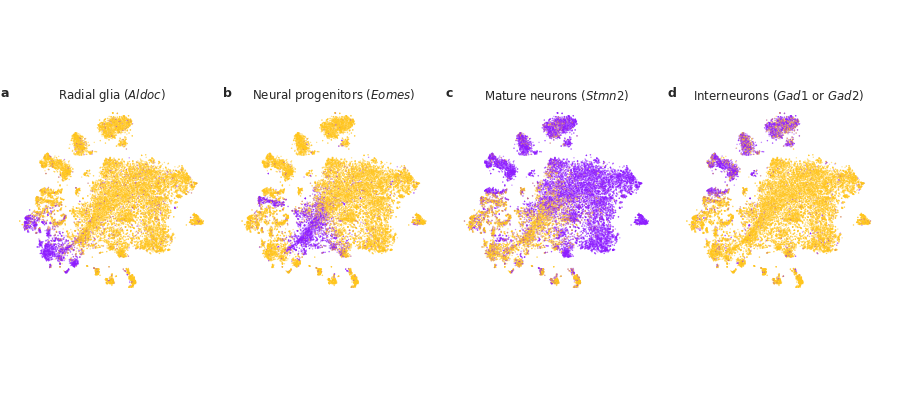

In [75]:
titles = ['Radial glia ' + r'($\mathit{Aldoc}$)',
          'Neural progenitors ' + r'($\mathit{Eomes}$)',
          'Mature neurons ' + r'($\mathit{Stmn2}$)',
          'Interneurons ' + r'($\mathit{Gad1}$ or $\mathit{Gad2}$)']

markers = [['Aldoc'], ['Eomes'], ['Stmn2'], ['Gad1', 'Gad2']]

plt.figure(figsize=(9,4))

for i,genes in enumerate(markers):
    detected = np.sum(markerexp[:, np.isin(markergenes, genes)], axis=1) > 0
    colors = ['#8e1cff' if c else '#ffc61c' for c in detected]
    plt.subplot(1, len(markers), i+1)
    plt.gca().set_aspect('equal')
    plt.scatter(-tsne[:,1], -tsne[:,0], s=1, c=colors, alpha=.5, 
                rasterized=True, edgecolor='none')
    plt.title(titles[i], va='center', fontsize = 8.5)
    plt.xticks([])
    plt.yticks([])
    

sns.despine(left=True, bottom=True)
plt.tight_layout()

letters = 'abcd'
for i,l in enumerate(letters):
    plt.text(-0.05, 1.035, l, transform = plt.gcf().get_axes()[i].transAxes, fontsize=9, fontweight='bold')